<a href="https://colab.research.google.com/github/gbzs-hue/PEE---2025/blob/main/C%C3%B3pia_de_C%C3%B3pia_de_TRB1_PEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ainda em falta:

*   ajustar os comentários durante o código (padronizar mais), escrever uma breve
*   introdução explicando objetivos,
*   colocar todas as bibliotecas que estão sendo usadas na primeira secção de código e explica-las no texto,
*   ajustar texto dos gráficos e alguns gráficos com subíndices e explicar cada parte,
*   fazer a parte de texto do reservatório
* Melhorar os atuais textos

Introdução
---
___

In [1]:
!git clone https://github.com/boffandre-cyber/PEE---2025.git

fatal: destination path 'PEE---2025' already exists and is not an empty directory.


Importando Biblitecas e suas funções
---
---
Esta secção de códogo é dedicada e importar todas as bibliotecas que serão utilizadas ao longo do projeto, sendo elas:
*   Pandas:
*   Numpy:
*   Matplotlib:



In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

Lendo o arquivo de dados
---
---
Inicialmente foi buscado um arquivo fluvial no site da ANA (Agencia Nacional das Águas) o qual está no formato csv, portanto deve-se ajusta-lo para a leitura correta pela Biblioteca Pandas, afim de fazer uma análise de dados posterior em forma de dataframe


In [6]:
# Esta função é necessária para lidar com o formato específico do arquivo,
# que contém metadados antes do cabeçalho.
import re # Import the re module

def read_complex_csv(file_path):
    """
    Lê um arquivo CSV com metadados e retorna um DataFrame.
    """
    with open(file_path, 'r', encoding='latin-1') as f:
        lines = f.readlines()

    # O cabeçalho está na linha 16 (índice 15).
    header_line = lines[15].strip()
    data_lines = lines[16:]

    # Obter os nomes das colunas, removendo aspas duplas.
    columns = [col.strip('"') for col in header_line.split(';')]

    # Processar as linhas de dados, removendo aspas e substituindo vírgulas por pontos.
    data = []
    for line in data_lines:
        if line.strip():  # Ignorar linhas vazias
            row = [re.sub(r'"', '', val).replace(',', '.') for val in line.split(';')]
            data.append(row)

    # Criar o DataFrame a partir dos dados processados.
    df = pd.DataFrame(data, columns=columns)

    # Remover colunas totalmente vazias ou sem nome
    df = df.dropna(axis=1, how='all')
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    return df

# Substitua '70100000_Vazoes_I.csv' pelo nome do arquivo.
file_path = 'PEE---2025/70100000_Vazoes_I.csv'
df = read_complex_csv(file_path)

Análise de Dados
---
___
Análise inicial de dados onde é ajustado os dados de vazões para estar em conformidade com o estipulado como premissa em edital da disciplina. Nela também são ajustadas as colunas que inicialmente são entendidas como variáveis de String, portanto são ajustadas datas na forma de DateTime e vazões como Float

In [7]:
# -----------------------------------------------------------------------------
# Início da análise
# -----------------------------------------------------------------------------

# Converter a coluna 'Data' para o formato de data
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')

# Encontrar o ano mais recente nos dados
most_recent_year = df['Data'].dt.year.max()
print(f"Ano mais recente nos dados: {most_recent_year}")

# Definir o ano de corte para desconsiderar os dois últimos anos
year_cutoff = most_recent_year - 1
print(f"Os dados serão filtrados até o ano de: {year_cutoff - 1}")

# Filtrar o DataFrame para excluir os dois últimos anos
df_filtered = df[df['Data'].dt.year < year_cutoff].copy()

# Identificar as colunas de vazão, excluindo aquelas que contêm a palavra 'Status'
vazao_cols = [col for col in df_filtered.columns if 'Vazao' in col and 'Status' not in col]
print(f"\nColunas de vazão encontradas: {vazao_cols}")

# Desempilhar o DataFrame para obter uma única coluna com todos os valores de vazão
df_melted_filtered = df_filtered.melt(value_vars=vazao_cols, value_name='Vazao')

# Converter a coluna 'Vazao' para tipo numérico e remover valores ausentes
df_melted_filtered['Vazao'] = pd.to_numeric(df_melted_filtered['Vazao'], errors='coerce')
df_melted_filtered.dropna(subset=['Vazao'], inplace=True)

# Calcular a vazão média de longo termo
long_term_avg = df_melted_filtered['Vazao'].mean()

print(f"\nVazão média de longo termo (excluindo os dois últimos anos): {long_term_avg:.2f} m³/s")

# Definir o intervalo de referência e o valor alvo
lower_bound = 30
upper_bound = 60
target_avg = 45 # Ponto central do intervalo

# Verificar se a vazão média está fora do intervalo
if not (lower_bound <= long_term_avg <= upper_bound):
    print(f"\nA vazão média de longo termo está fora do intervalo [{lower_bound}, {upper_bound}] m³/s.")
    print("Aplicando fator de correção.")

    # Calcular o fator de correção
    correction_factor = target_avg / long_term_avg
    print(f"Fator de correção calculado: {correction_factor:.4f}")

    # Criar uma cópia do DataFrame original para aplicar a correção
    df_corrected = df.copy()

    # Aplicar o fator de correção a todas as colunas de vazão
    for col in vazao_cols:
        df_corrected[col] = pd.to_numeric(df_corrected[col], errors='coerce').mul(correction_factor)

    # Recalcular a média de longo termo com os dados corrigidos para verificação
    df_melted_corrected = df_corrected.melt(value_vars=vazao_cols, value_name='Vazao')
    df_melted_corrected['Vazao'] = pd.to_numeric(df_melted_corrected['Vazao'], errors='coerce')
    corrected_avg = df_melted_corrected['Vazao'].mean()
    print(f"Nova vazão média de longo termo após correção: {corrected_avg:.2f} m³/s")

    # Salvar o DataFrame corrigido em um novo arquivo CSV
    df_corrected.to_csv('70100000_Vazoes_I_Corrigido.csv', sep=';', index=False, decimal=',')
    print("\nUm novo arquivo CSV com os dados corrigidos foi gerado e está disponível como '70100000_Vazoes_I_Corrigido.csv'.")
else:
    print(f"\nA vazão média de longo termo já está dentro do intervalo [{lower_bound}, {upper_bound}] m³/s. Nenhuma correção é necessária.")


# Ajustantdo as colunas de media minima e maxima do df
df_corrected['Media'] = pd.to_numeric(df_corrected['Media'], errors='coerce')
df_corrected['Minima'] = pd.to_numeric(df_corrected['Minima'], errors='coerce')
df_corrected['Maxima'] = pd.to_numeric(df_corrected['Maxima'], errors='coerce')



for col in ['Media', 'Minima', 'Maxima']:
    df_corrected[col] = df_corrected[col] * correction_factor

# Criando uma coluna de mediana:
df_corrected['Mediana'] = df_corrected[vazao_cols].median(axis=1)

Ano mais recente nos dados: 2025
Os dados serão filtrados até o ano de: 2023

Colunas de vazão encontradas: ['Vazao01', 'Vazao02', 'Vazao03', 'Vazao04', 'Vazao05', 'Vazao06', 'Vazao07', 'Vazao08', 'Vazao09', 'Vazao10', 'Vazao11', 'Vazao12', 'Vazao13', 'Vazao14', 'Vazao15', 'Vazao16', 'Vazao17', 'Vazao18', 'Vazao19', 'Vazao20', 'Vazao21', 'Vazao22', 'Vazao23', 'Vazao24', 'Vazao25', 'Vazao26', 'Vazao27', 'Vazao28', 'Vazao29', 'Vazao30', 'Vazao31']

Vazão média de longo termo (excluindo os dois últimos anos): 16.96 m³/s

A vazão média de longo termo está fora do intervalo [30, 60] m³/s.
Aplicando fator de correção.
Fator de correção calculado: 2.6526
Nova vazão média de longo termo após correção: 45.31 m³/s

Um novo arquivo CSV com os dados corrigidos foi gerado e está disponível como '70100000_Vazoes_I_Corrigido.csv'.


Plotagem dos Gráficos
---
___
Aqui são plotados os gráficos de vazões para o histórico de 40 anos. São feitos os gráficos da vazão média mensal e curva de carga para todo o histórico.
Também nesta secção se encontra a criação de um ano sintético o qual foi utilizado para fazer os gráficos das médias mensais e de Rippl.

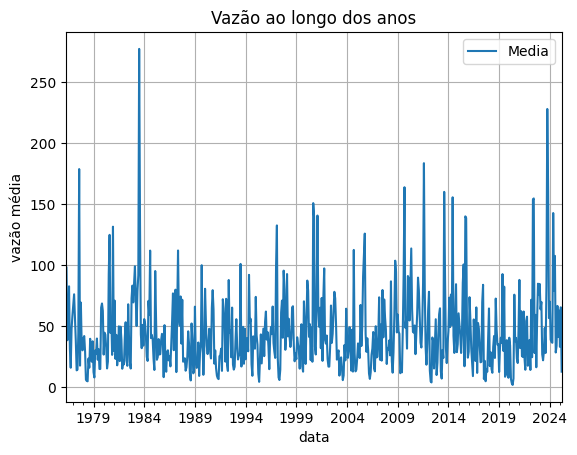

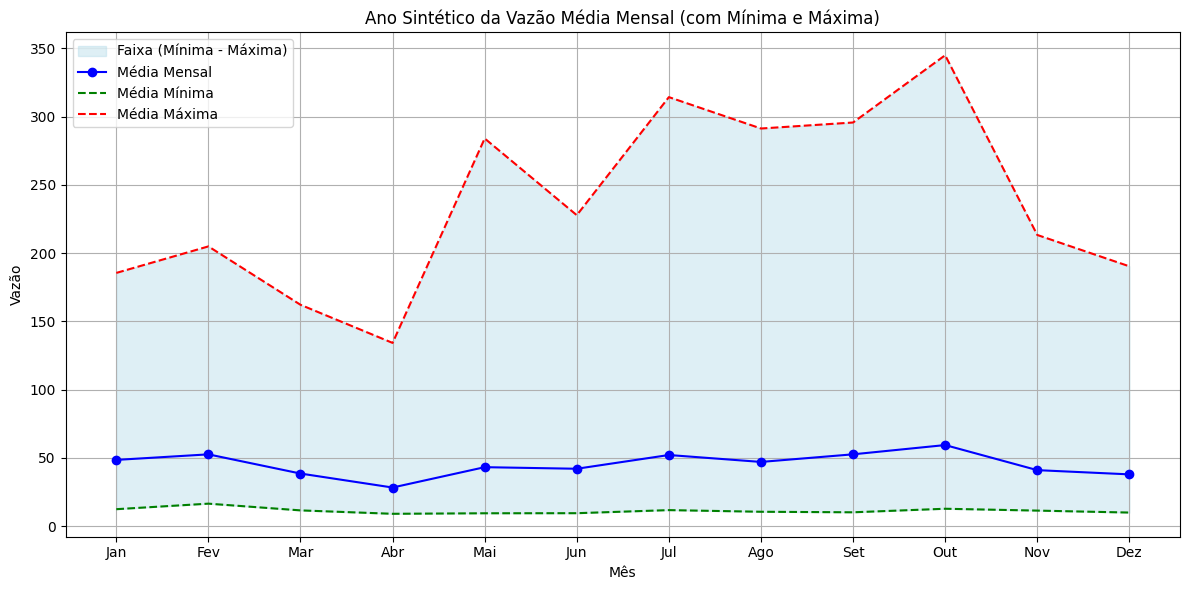

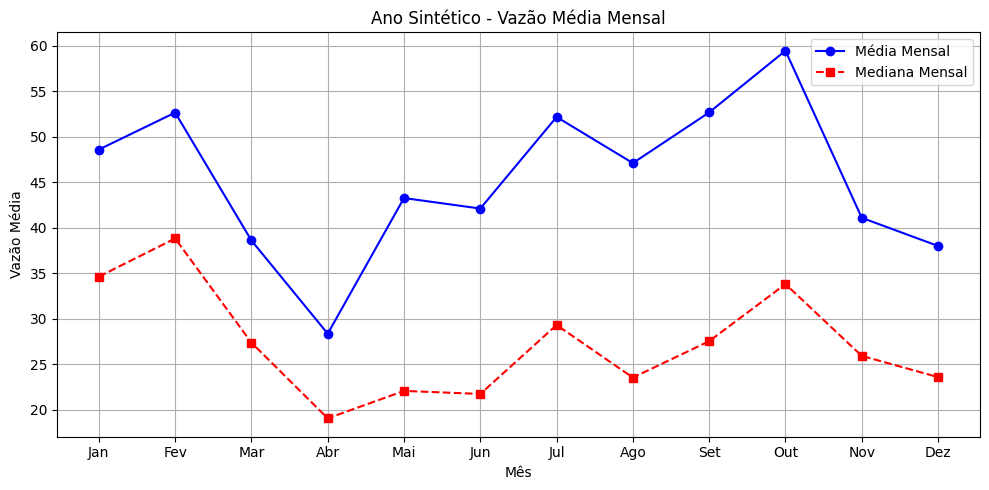

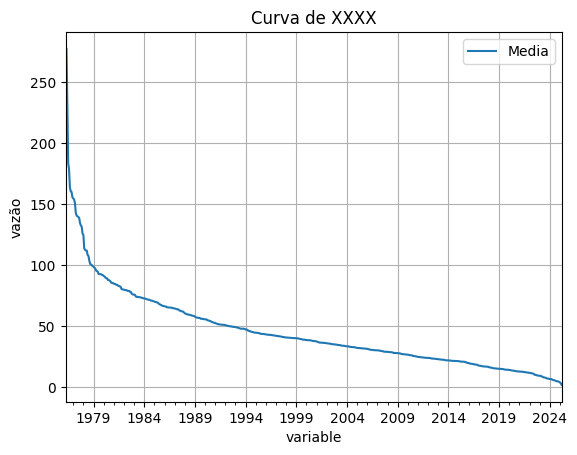

In [8]:
#grafico de vazao da média mensal de todos os anos
df_corrected


#plotando todos os valores de média
df_corrected.plot(x='Data', y='Media', kind='line')
plt.title('Vazão ao longo dos anos')
plt.xlabel('data')
plt.ylabel('vazão média')
plt.grid(True)
plt.show()

#aqui plotar sazonalidades fazer media das medias, das minimas e das maximas dos meses.
df_anosintetico = df_corrected
# Extrai o mês da data
df_anosintetico['Mes'] = df_anosintetico['Data'].dt.month

# Agrupa por mês e calcula a média das médias, minimas, máximas e medianas:
media_mensal_sintetica = df_anosintetico.groupby('Mes')['Media'].mean().reset_index()
media_minima_sintetica = df_anosintetico.groupby('Mes')['Minima'].mean().reset_index()
media_maxima_sintetica = df_anosintetico.groupby('Mes')['Maxima'].mean().reset_index()
mediana_mensal_sintetica = df_anosintetico.groupby('Mes')['Mediana'].mean().reset_index()

# Dicionário para converter número do mês em nome
meses = {
    1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'Mai', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez'
}
media_mensal_sintetica['MesNome'] = media_mensal_sintetica['Mes'].map(meses)
media_minima_sintetica['MesNome'] = media_mensal_sintetica['Mes'].map(meses)
media_maxima_sintetica['MesNome'] = media_mensal_sintetica['Mes'].map(meses)
mediana_mensal_sintetica['MesNome'] = mediana_mensal_sintetica['Mes'].map(meses)

# Ordena corretamente os meses
media_mensal_sintetica = media_mensal_sintetica.sort_values('Mes')


# Junta os três DataFrames em um só, usando 'Mes' como chave
df_plot = media_mensal_sintetica[['Mes', 'Media']].copy()
df_plot['Minima'] = media_minima_sintetica['Minima']
df_plot['Maxima'] = media_maxima_sintetica['Maxima']
df_plot['MesNome'] = df_plot['Mes'].map(meses)

# Ordena corretamente os meses
df_plot = df_plot.sort_values('Mes')

# Plotagem
plt.figure(figsize=(12, 6))

# Faixa entre mínima e máxima
plt.fill_between(
    df_plot['MesNome'],
    df_plot['Minima'],
    df_plot['Maxima'],
    color='lightblue',
    alpha=0.4,
    label='Faixa (Mínima - Máxima)'
)

# Linha da média
plt.plot(df_plot['MesNome'], df_plot['Media'], marker='o', color='blue', label='Média Mensal')

# Linha da mínima
plt.plot(df_plot['MesNome'], df_plot['Minima'], linestyle='--', color='green', label='Média Mínima')

# Linha da máxima
plt.plot(df_plot['MesNome'], df_plot['Maxima'], linestyle='--', color='red', label='Média Máxima')

# Ajustes do gráfico
plt.title('Ano Sintético da Vazão Média Mensal (com Mínima e Máxima)')
plt.xlabel('Mês')
plt.ylabel('Vazão')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Plotando a média
plt.figure(figsize=(10, 5))

# Linha da média mensal
plt.plot(media_mensal_sintetica['MesNome'], media_mensal_sintetica['Media'],
         marker='o', color='blue', label='Média Mensal')

# Linha da mediana mensal
plt.plot(
    mediana_mensal_sintetica['MesNome'], mediana_mensal_sintetica['Mediana'],
    marker='s', color='red', linestyle='--', label='Mediana Mensal'
)

# Ajustes do gráfico
plt.title('Ano Sintético - Vazão Média Mensal')
plt.xlabel('Mês')
plt.ylabel('Vazão Média')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Plota o gráfico de XXX
df_ordenado = df_corrected
df_ordenado['Media'] = sorted(df_ordenado['Media'])
df_corrected.plot(x='Data', y='Media', kind='line')
plt.title('Curva de XXXX')
plt.xlabel('variable')
plt.ylabel('vazão')
plt.grid(True)
plt.show()


Grafico de Rippl
---

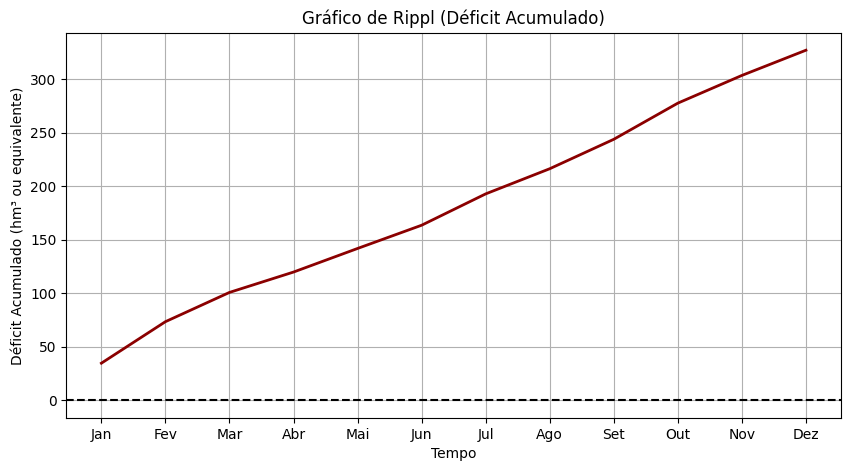

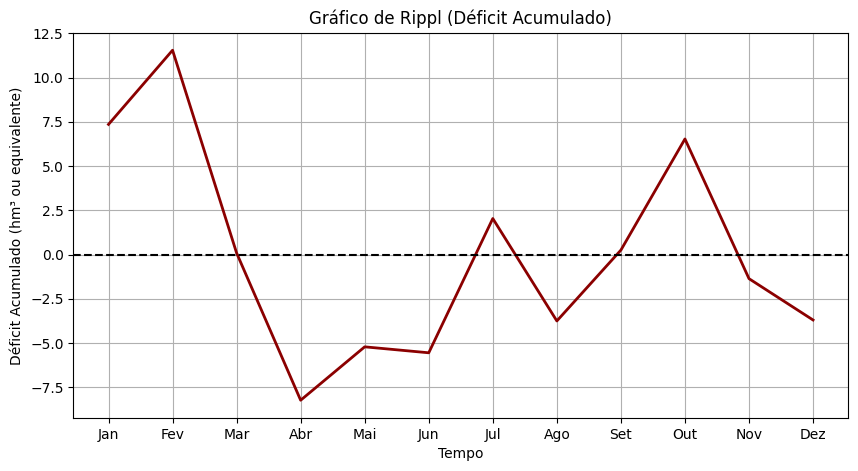

O valor máximo de Rippl é: 11.540878290212198
O valor mínimo de Rippl é: -8.227621315079404
O valor da regularização do reservatório é: 19.768499605291602


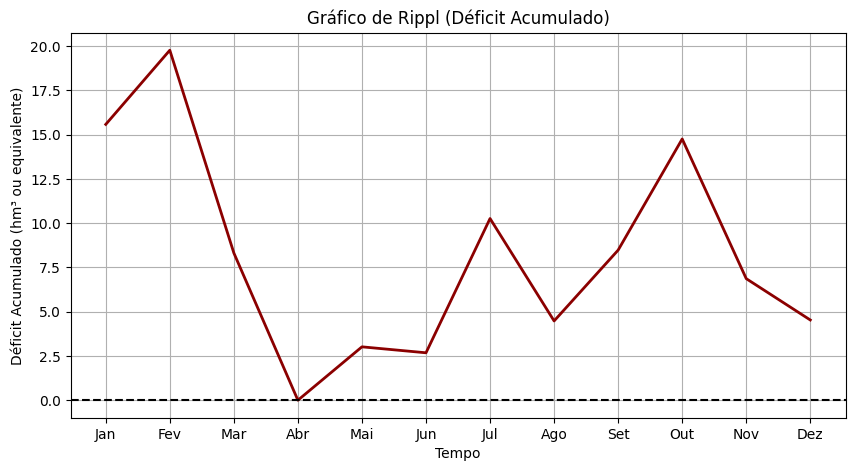

In [11]:
# Definir a série de vazões a ser usada
serie_vazao = mediana_mensal_sintetica['Mediana']
vazão_acumulado = serie_vazao.cumsum()
media_medianas = mediana_mensal_sintetica['Mediana'].mean()

# Plotando a figura
plt.figure(figsize=(10, 5))
plt.plot(mediana_mensal_sintetica['MesNome'], vazão_acumulado, color='darkred', linewidth=2)
plt.axhline(0, color='black', linestyle='--')
plt.title('Gráfico de Rippl (Déficit Acumulado)')
plt.xlabel('Tempo')
plt.ylabel('Déficit Acumulado (hm³ ou equivalente)')
plt.grid(True)


# Rippl
Rippl_mensal = serie_vazao - media_medianas
# Plotar gráfico de Rippl
plt.figure(figsize=(10, 5))
plt.plot(media_mensal_sintetica['MesNome'], Rippl_mensal, color='darkred', linewidth=2)
plt.axhline(0, color='black', linestyle='--')
plt.title('Gráfico de Rippl (Déficit Acumulado)')
plt.xlabel('Tempo')
plt.ylabel('Déficit Acumulado (hm³ ou equivalente)')
plt.grid(True)
plt.show()

# Ajustando o gráfico de Rippl para tamanho do reservatório
Rippl_maximo = Rippl_mensal.max()
Rippl_minimo = Rippl_mensal.min()
reservatorio_regularizacao = Rippl_maximo - Rippl_minimo
print(f"O valor máximo de Rippl é: {Rippl_maximo}")
print(f"O valor mínimo de Rippl é: {Rippl_minimo}")
print(f"O valor da regularização do reservatório é: {reservatorio_regularizacao}")


Rippl_corrigido = Rippl_mensal - Rippl_minimo

plt.figure(figsize=(10, 5))
plt.plot(media_mensal_sintetica['MesNome'], Rippl_corrigido, color='darkred', linewidth=2)
plt.axhline(0, color='black', linestyle='--')
plt.title('Gráfico de Rippl (Déficit Acumulado)')
plt.xlabel('Tempo')
plt.ylabel('Déficit Acumulado (hm³ ou equivalente)')
plt.grid(True)

# Turbina

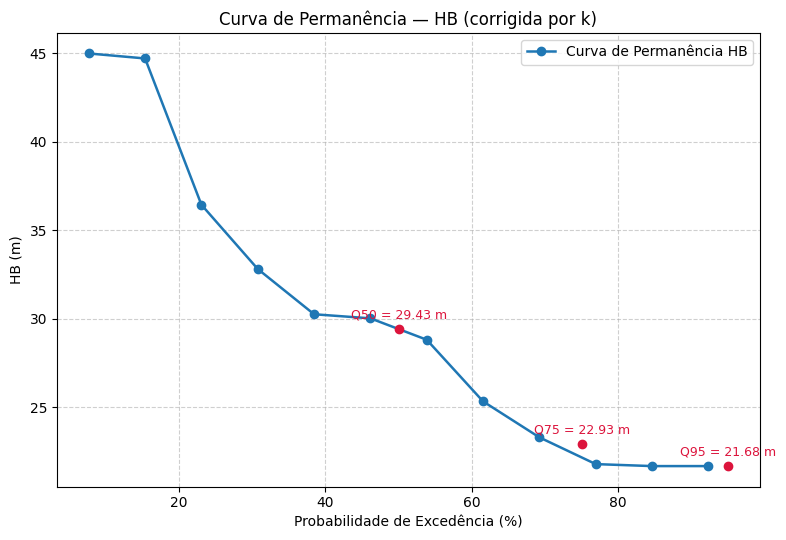


HBmax = 45.00 m | max(b_f) = 23.32 m | k = 21.682 m

Quantis HB:
Quantil  HB (m)
    Q50  29.426
    Q75  22.926
    Q95  21.682

Arquivo Excel salvo em: /content/PEE---2025/HB_Permanencia.xlsx


In [ ]:
# Determinação da queda de referência, também chamada de queda líquida nominal, utilizada para determinar
# a turbina de forma a garantir que o gerador forneça potência nominal em 95% do tempo.
# HB é a altura topográfica
# ============================================================
# Curva de Permanência HB a partir de b_f (m) + ajuste por k
# Lê: /content/PEE---2025/BalancoReservatorio_comPE_.xlsx
# Salva: /content/PEE---2025/HB_Permanencia.xlsx  (ou CSVs como fallback)
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

HBMAX = 45.0  # m
BASE_DIR = r"/content/PEE---2025/" # Corrected path
ARQ_IN  = os.path.join(BASE_DIR, "BalancoReservatorio_comPE_.xlsx")
ARQ_OUT = os.path.join(BASE_DIR, "HB_Permanencia.xlsx")

def _col(df, nome):
    alvo = nome.strip().lower()
    for k in df.columns:
        if k.strip().lower() == alvo:
            return k
    raise KeyError(f"Coluna '{nome}' não encontrada. Colunas: {list(df.columns)}")

# ----- localizar arquivo (fallback p/ pasta atual) -----
if not os.path.exists(ARQ_IN):
    cand = [p for p in os.listdir(".") if p.lower() == "Balancoreservatorio_comPE_.xlsx"]
    if cand:
        ARQ_IN = cand[0]
        ARQ_OUT = os.path.join(os.getcwd(), "HB_Permanencia.xlsx")
    else:
        raise FileNotFoundError("Não encontrei 'BalancoReservatorio_comPE_.xlsx'.")

# ----- leitura -----
df = pd.read_excel(ARQ_IN)
col_bf = _col(df, "b_f (m)")
bf = pd.to_numeric(df[col_bf], errors="coerce").dropna().to_numpy(dtype=float)
if bf.size == 0:
    raise ValueError("A coluna 'b_f (m)' não contém valores numéricos válidos.")

# ----- ajuste por k -----
k = HBMAX - float(np.nanmax(bf))
HB = bf + k

# ----- curva de permanência -----
HB_sorted   = np.sort(HB)[::-1]
n           = len(HB_sorted)
exceed_prob = (np.arange(1, n+1) / (n+1)) * 100.0  # %

# ----- quantis (excedência) -----
quantis     = [50, 75, 95]  # em %
HB_quantis  = np.percentile(HB, [100 - q for q in quantis])

# ----- gráfico -----
plt.figure(figsize=(8, 5.5))
plt.plot(exceed_prob, HB_sorted, marker="o", lw=1.8, label="Curva de Permanência HB")
for q, hq in zip(quantis, HB_quantis):
    plt.scatter(q, hq, color="crimson", zorder=5)
    plt.text(q, hq + 0.6, f"Q{q} = {hq:.2f} m", color="crimson", ha="center", fontsize=9)
plt.xlabel("Probabilidade de Excedência (%)")
plt.ylabel("HB (m)")
plt.title("Curva de Permanência — HB (corrigida por k)")
plt.grid(True, ls="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ----- tabelas -----
tab_perm = pd.DataFrame({"Excedência (%)": np.round(exceed_prob, 2),
                         "HB_sorted (m)":  np.round(HB_sorted, 3)})
tab_quantis = pd.DataFrame({"Quantil": [f"Q{q}" for q in quantis],
                            "HB (m)":  np.round(HB_quantis, 3)})

print(f"\nHBmax = {HBMAX:.2f} m | max(b_f) = {np.max(bf):.2f} m | k = {k:.3f} m")
print("\nQuantis HB:")
print(tab_quantis.to_string(index=False))

# ----- salvar em Excel (preferir openpyxl; se não houver, salvar CSVs) -----
try:
    os.makedirs(os.path.dirname(ARQ_OUT), exist_ok=True)
except Exception:
    ARQ_OUT = os.path.join(os.getcwd(), "HB_Permanencia.xlsx")

try:
    # tenta com openpyxl (sem precisar especificar engine se estiver instalado)
    with pd.ExcelWriter(ARQ_OUT, engine="openpyxl") as xlw:
        tab_perm.to_excel(xlw, index=False, sheet_name="Permanencia")
        tab_quantis.to_excel(xlw, index=False, sheet_name="Quantis")
    print(f"\nArquivo Excel salvo em: {ARQ_OUT}")
except Exception as e:
    # fallback para CSVs
    csv1 = os.path.join(os.path.dirname(ARQ_OUT), "HB_Permanencia_Permanencia.csv")
    csv2 = os.path.join(os.path.dirname(ARQ_OUT), "HB_Permanencia_Quantis.csv")
    tab_perm.to_csv(csv1, index=False, encoding="utf-8")
    tab_quantis.to_csv(csv2, index=False, encoding="utf-8")
    print("\n(openpyxl/xlsxwriter indisponível) Salvei como CSV:")
    print(f" - {csv1}")
    print(f" - {csv2}")

=== Parâmetros de Projeto ===
Q_médio = 27.267 m³/s  (Reservatorio_1.xlsx C2)
HB_Q95  = 21.682 m  |  HBmax = 45.00 m  |  k = 21.682 m

=== Tabela típica de aplicação (H × Q) ===


,Turbina,H_min (m),H_max (m),Q_min (m3/s),Q_max (m3/s),Observações
0,Pelton,50,1000,0.1,20,"Altas quedas, baixas vazões (múltiplos jatos)"
1,Francis,20,300,1.0,200,"Versátil, quedas médias"
2,Francis Casa Aberta,10,60,1.0,50,Variante para quedas mais baixas
3,Kaplan (S/hélice),2,30,10.0,1000,"Baixa queda, alta vazão"
4,Bulbo c/ Multiplicador,2,20,20.0,2000,"Fio d’água, quedas muito baixas"



=== Turbinas aplicáveis ao projeto ===


,Turbina,H_min (m),H_max (m),Q_min (m3/s),Q_max (m3/s),Observações
0,Francis,20,300,1.0,200,"Versátil, quedas médias"
1,Francis Casa Aberta,10,60,1.0,50,Variante para quedas mais baixas
2,Kaplan (S/hélice),2,30,10.0,1000,"Baixa queda, alta vazão"


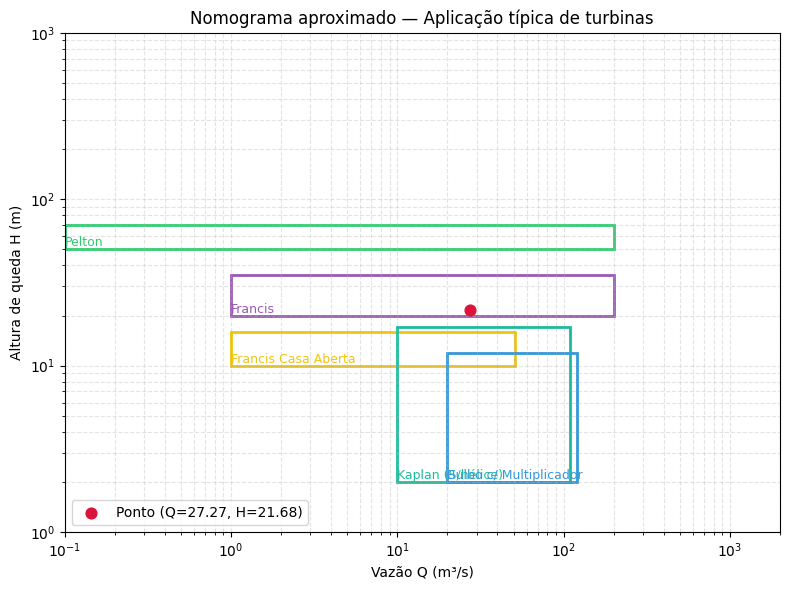


Arquivo Excel salvo em: /content/PEE---2025/Selecao_Turbinas.xlsx


In [ ]:
# ============================================================
# Seleção de turbinas (HB limitado a 45 m) + Excel + nomograma
# Lê:
#   - /content/PEE---2025/Reservatorio_1.xlsx  (C2 = Q_médio [m3/s])
#   - /content/PEE---2025/BalancoReservatorio_comPE_.xlsx (coluna 'b_f (m)')
# Salva:
#   - /content/PEE---2025/Selecao_Turbinas.xlsx  (fallback: diretório atual)
# ============================================================

import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ---------------- Caminhos ----------------
BASE = r"/content/PEE---2025/" # Corrected path
ARQ_Q  = os.path.join(BASE, "Reservatorio_1.xlsx")
ARQ_BF = os.path.join(BASE, "BalancoReservatorio_comPE_.xlsx")
ARQ_OUT= os.path.join(BASE, "Selecao_Turbinas.xlsx")

HBMAX = 45.0  # ---> DEFINIÇÃO DE PROJETO (ALTURA MÁXIMA)

def _fallback(expected, exact_lower):
    if os.path.exists(expected):
        return expected
    cand = [p for p in os.listdir(".") if p.lower() == exact_lower]
    if cand:
        return cand[0]
    return expected

def _col(df, nome):
    alvo = nome.strip().lower()
    for k in df.columns:
        if k.strip().lower() == alvo:
            return k
    raise KeyError(f"Coluna '{nome}' não encontrada. Colunas: {list(df.columns)}")

ARQ_Q  = _fallback(ARQ_Q,  "reservatorio_1.xlsx") # Corrected lowercase filename
ARQ_BF = _fallback(ARQ_BF, "balancoreservatorio_compe_.xlsx")

# -------- 1) Ler Q_médio (B2) --------
if not os.path.exists(ARQ_Q):
    raise FileNotFoundError(f"Não encontrei o arquivo: {ARQ_Q}")
sheet_q = pd.read_excel(ARQ_Q, header=None)
Q_medio = float(sheet_q.iat[1, 2])  # C2

# -------- 2) Série HB a partir de b_f (m) com k e LIMITE HBMAX --------
if not os.path.exists(ARQ_BF):
    raise FileNotFoundError(f"Não encontrei o arquivo: {ARQ_BF}")
df_b = pd.read_excel(ARQ_BF)
col_bf = _col(df_b, "b_f (m)")
bf = pd.to_numeric(df_b[col_bf], errors="coerce").dropna().to_numpy(float)
if bf.size == 0:
    raise ValueError("A coluna 'b_f (m)' não contém números válidos.")

# Centraliza a série para que o máximo coincida com HBMAX e CLIPA em [0, HBMAX]
k  = HBMAX - float(np.nanmax(bf))
HB = np.clip(bf + k, 0.0, HBMAX)

# HB_Q95 (excedência 95% -> percentil 5), garantindo <= HBMAX
HB_Q95 = float(np.percentile(HB, 5))
HB_Q95 = min(HB_Q95, HBMAX)

# -------- 3) Tabela típica (faixas H × Q) --------
turbinas = pd.DataFrame([
    ["Pelton",                 50, 1000,   0.1,    20,    "Altas quedas, baixas vazões (múltiplos jatos)"],
    ["Francis",                20,  300,   1.0,   200,    "Versátil, quedas médias"],
    ["Francis Casa Aberta",    10,   60,   1.0,    50,    "Variante para quedas mais baixas"],
    ["Kaplan (S/hélice)",       2,   30,  10.0,  1000,    "Baixa queda, alta vazão"],
    ["Bulbo c/ Multiplicador",  2,   20,  20.0,  2000,    "Fio d’água, quedas muito baixas"],
], columns=["Turbina", "H_min (m)", "H_max (m)", "Q_min (m3/s)", "Q_max (m3/s)", "Observações"])

# -------- 4) Turbinas aplicáveis --------
H = HB_Q95
Q = Q_medio
mask = (H >= turbinas["H_min (m)"]) & (H <= turbinas["H_max (m)"]) & \
       (Q >= turbinas["Q_min (m3/s)"]) & (Q <= turbinas["Q_max (m3/s)"])
aplicaveis = turbinas[mask].reset_index(drop=True)

print("=== Parâmetros de Projeto ===")
print(f"Q_médio = {Q:.3f} m³/s  (Reservatorio_1.xlsx C2)")
print(f"HB_Q95  = {H:.3f} m  |  HBmax = {HBMAX:.2f} m  |  k = {k:.3f} m\n")

print("=== Tabela típica de aplicação (H × Q) ===")
display(turbinas)

if aplicaveis.empty:
    # Sugestão (distância em log-space ao envelope)
    import math
    def _dist_log_rect(Hv, Qv, row):
        Hmin, Hmax = row["H_min (m)"], row["H_max (m)"]
        Qmin, Qmax = row["Q_min (m3/s)"], row["Q_max (m3/s)"]
        Hc = min(max(Hv, Hmin), Hmax)
        Qc = min(max(Qv, Qmin), Qmax)
        return math.hypot(math.log10(Hv) - math.log10(Hc),
                          math.log10(Qv) - math.log10(Qc))

    sugestoes = turbinas.copy()
    sugestoes["Score (↓ melhor)"] = sugestoes.apply(lambda r: _dist_log_rect(H, Q, r), axis=1)
    sugestoes = sugestoes.sort_values("Score (↓ melhor)").reset_index(drop=True)

    print("\nNenhuma turbina enquadrou simultaneamente H e Q.")
    print("Sugestão ranqueada (menor distância log-HQ ao envelope):")
    display(sugestoes)
else:
    print("\n=== Turbinas aplicáveis ao projeto ===")
    display(aplicaveis[["Turbina","H_min (m)","H_max (m)","Q_min (m3/s)","Q_max (m3/s)","Observações"]])

# -------- 5) Nomograma aproximado (log–log) --------
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_xlim(0.1, 2000); ax.set_ylim(1, 1000)
ax.set_xlabel("Vazão Q (m³/s)")
ax.set_ylabel("Altura de queda H (m)")
ax.set_title("Nomograma aproximado — Aplicação típica de turbinas")

colors = {
    "Pelton": "#2ecc71",
    "Francis": "#9b59b6",
    "Francis Casa Aberta": "#f1c40f",
    "Kaplan (S/hélice)": "#1abc9c",
    "Bulbo c/ Multiplicador": "#3498db",
}
for _, r in turbinas.iterrows():
    x, y = r["Q_min (m3/s)"], r["H_min (m)"]
    w = r["Q_max (m3/s)"] / r["Q_min (m3/s)"]
    h = r["H_max (m)"] / r["H_min (m)"]
    rect = Rectangle((x, y), w, h, fill=False, lw=2,
                     edgecolor=colors.get(r["Turbina"], "k"),
                     transform=ax.transData)
    ax.add_patch(rect)
    ax.text(x, y, r["Turbina"], color=colors.get(r["Turbina"], "k"),
            fontsize=9, va="bottom", ha="left")

# Ponto de projeto (com HB limitado a 45 m)
ax.scatter([Q], [H], s=60, c="crimson", zorder=5, label=f"Ponto (Q={Q:.2f}, H={H:.2f})")
ax.legend(loc="lower left")
ax.grid(True, which="both", ls="--", alpha=0.35)
plt.tight_layout()
plt.show()

# -------- 6) Salvar Excel --------
parametros = pd.DataFrame({
    "Parametro": ["Q_medio (m3/s)", "HB_Q95 (m)", "k (m)", "HBmax (m)"],
    "Valor":     [Q, H, k, HBMAX]
})
hb_serie = pd.DataFrame({"HB (m)": np.round(HB, 3)})

try:
    os.makedirs(os.path.dirname(ARQ_OUT), exist_ok=True)
except Exception:
    ARQ_OUT = os.path.join(os.getcwd(), "Selecao_Turbinas.xlsx")

try:
    with pd.ExcelWriter(ARQ_OUT, engine="openpyxl") as xlw:
        turbinas.to_excel(xlw, index=False, sheet_name="Tabela_Tipica")
        (aplicaveis if not aplicaveis.empty else turbinas.iloc[0:0]).to_excel(
            xlw, index=False, sheet_name="Aplicaveis"
        )
        parametros.to_excel(xlw, index=False, sheet_name="Parametros")
        hb_serie.to_excel(xlw, index=False, sheet_name="HB_Serie")
    print(f"\nArquivo Excel salvo em: {ARQ_OUT}")
except Exception as e:
    # fallback CSVs
    base_dir = os.path.dirname(ARQ_OUT) or "."
    p1 = os.path.join(base_dir, "Selecao_Turbinas_TabelaTipica.csv")
    p2 = os.path.join(base_dir, "Selecao_Turbinas_Aplicaveis.csv")
    p3 = os.path.join(base_dir, "Selecao_Turbinas_Parametros.csv")
    p4 = os.path.join(base_dir, "Selecao_Turbinas_HB_Serie.csv")
    turbinas.to_csv(p1, index=False, encoding="utf-8")
    (aplicaveis if not aplicaveis.empty else turbinas.iloc[0:0]).to_csv(p2, index=False, encoding="utf-8")
    parametros.to_csv(p3, index=False, encoding="utf-8")
    hb_serie.to_csv(p4, index=False, encoding="utf-8")
    print("\n(openpyxl indisponível) Salvei como CSV:")
    print(" -", p1)
    print(" -", p2)
    print(" -", p3)
    print(" -", p4)

In [ ]:
# Definição da Potência mecânica-motriz da Turbina
# Cálculos hidráulicos básicos
# a) Perda na tomada de água = z * HB,        z = 2,5% (=0.025)
# b) Perda na adução        = (HB - Perda_tomada) * (1 - N), N = 0.75
# c) Altura disponível      = HB - (Perda_tomada + Perda_adução)
# d) Potência hidráulica (cv) = (1000 * Q_medio) * Altura_disponivel
# ============================================================

# Parâmetros fixos
z = 0.025   # 2,5%
N = 0.75    # rendimento (fração para adução)

# Tenta usar variáveis já existentes; se não houver, pede via input
def _get_var(name, prompt):
    try:
        return float(globals()[name])
    except Exception:
        while True:
            try:
                return float(input(prompt).replace(",", "."))
            except Exception:
                print("Valor inválido. Tente novamente.")

HB = _get_var("HB_Q95", "Informe HB (m): ")
Q_medio = _get_var("Q_medio", "Informe Q_medio (m³/s): ")

# Cálculos
perda_tomada = z * HB
perda_aducao = (HB - perda_tomada) * (1 - N)
altura_disp  = HB - (perda_tomada + perda_aducao)
pot_hid_cv   = (1000.0 * Q_medio) * altura_disp
pot_hid_kw   = pot_hid_cv * 0.0007357

# Impressão formatada
print("=== Resultados ===")
print(f"HB (altura bruta)                    : {HB:,.3f} m")
print(f"Q_medio (vazão média)                : {Q_medio:,.3f} m³/s")
print(f"Perda na tomada de água (z=2,5%)     : {perda_tomada:,.3f} m")
print(f"Perda na tubulação de adução (N=0,75): {perda_aducao:,.3f} m")
print(f"Altura disponível                     : {altura_disp:,.3f} m")
print(f"Potência hidráulica (cv)              : {pot_hid_cv:,.3f} cv")
print (f"Potência hidráulica (MW)              : {pot_hid_kw:,.3f} MW")
#


Informe HB (m): 21.68
=== Resultados ===
HB (altura bruta)                    : 21.680 m
Q_medio (vazão média)                : 27.267 m³/s
Perda na tomada de água (z=2,5%)     : 0.542 m
Perda na tubulação de adução (N=0,75): 5.284 m
Altura disponível                     : 15.854 m
Potência hidráulica (cv)              : 432,277.384 cv
Potência hidráulica (MW)              : 318.026 MW
